In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.inference import DBNInference

c:\Users\elkan\anaconda3\envs\time_series\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generate continuous data 

Le modèle créé correspond à ce cas: 
$$ X_{1} \rightarrow X_{2} \rightarrow Y $$ 

Pour cela, nous allons supposer que: 
$$ X_{1, t+1} = X_{1, t} + \epsilon_{1}, \epsilon_{1} \sim N(0, 5) $$
$$ X_{2, t+1} =  \frac{X_{1, t+1} + X_{1, t}}{2} - 0,5\times X_{2, t} + \epsilon_{2},  \epsilon_{2} \sim N(0, 1) $$
$$ Y = abs(X_{2, t+1}) + \epsilon_{3},  \epsilon_{3} \sim N(0, 1) $$

In [2]:
# function to generate data 

def generate_data(nb):
    """
    Given an integer generate data as describe above.

    :params nb: int 
        Number of datapoints to generate

    :return dictionary 
        Keys are "States" and "Observations". 
    """
    
    # initialize state vector 
    X1 = np.zeros(nb, dtype=np.float64)
    X2 = np.zeros(nb, dtype=np.float64)
    Y = np.zeros(nb, dtype=np.float64)

    # generate random variables 
    epsilon_1 = np.random.normal(0, scale=5, size=nb-1)
    epsilon_2 = np.random.normal(10, scale=1, size=nb-1)
    epsilon_3 = np.random.normal(0, scale=1, size=nb-1)

    for i in range(0, nb):
        """if i == 0: 
            X1[i] = np.random.uniform(-150, 150)
            X2[i] = np.random.uniform(-150, 150)
            Y[i] = np.random.uniform(-150, 150)
            continue"""

        X1[i] = X1[i-1] + epsilon_1[i-1]
        # X2[i] = .5 * (X1[i] + X1[i-1]) - X2[i-1] + epsilon_2[i-1]
        X2[i] = .33 * (X1[i] + X1[i-1] + X2[i-1]) + epsilon_2[i-1]
        Y[i] = np.abs(X2[i]) + epsilon_3[i-1]

    return X1, X2, Y

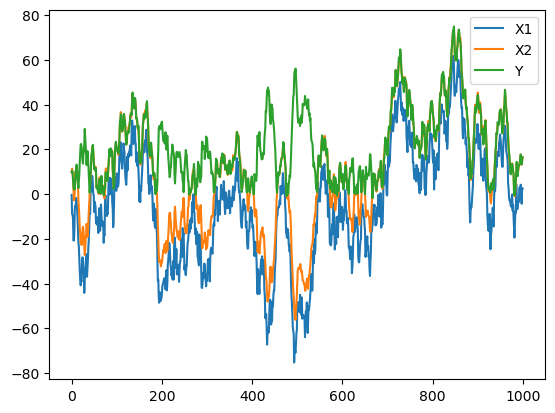

In [3]:
# nb of points 
nb_points = 1000

X1, X2, Y = generate_data(nb_points)
x_axis = np.arange(nb_points)

plt.plot(x_axis, X1, label="X1")
plt.plot(x_axis, X2, label='X2')
plt.plot(x_axis, Y, label="Y")

plt.legend()
plt.show()

Maintenant, pour avoir une quanitté importante de données, je génère plusieurs chemins différents:

In [4]:
"""# nb of paths
nb_paths = 1000

datasets = [generate_data(nb_points) for _ in range(nb_paths)]

# construct dataframe as required by DBN class
matrix = np.zeros((nb_paths, nb_points*3))
for i in range(nb_paths):
    X1, X2, Y = datasets[i]
    for j in range(nb_points):
        matrix[i, 3*j] = X1[j]
        matrix[i, 3*j+1] = X2[j]
        matrix[i, 3*j+2] = X2[j]

# name columns as required by DBN class
columns = []
for j in range(nb_points):
    columns.extend([("X1", j), ("X2", j), ("Y", j)])

my_df = pd.DataFrame(matrix, columns=columns)

my_df.head()"""

'# nb of paths\nnb_paths = 1000\n\ndatasets = [generate_data(nb_points) for _ in range(nb_paths)]\n\n# construct dataframe as required by DBN class\nmatrix = np.zeros((nb_paths, nb_points*3))\nfor i in range(nb_paths):\n    X1, X2, Y = datasets[i]\n    for j in range(nb_points):\n        matrix[i, 3*j] = X1[j]\n        matrix[i, 3*j+1] = X2[j]\n        matrix[i, 3*j+2] = X2[j]\n\n# name columns as required by DBN class\ncolumns = []\nfor j in range(nb_points):\n    columns.extend([("X1", j), ("X2", j), ("Y", j)])\n\nmy_df = pd.DataFrame(matrix, columns=columns)\n\nmy_df.head()'

In [5]:
X1, X2, Y = generate_data(nb_points)

# construct dataframe as required by DBN class
matrix = np.zeros((nb_points-1, 3*2))  # 2-TBN with 3 variables
for i in range(nb_points-1):
    matrix[i, 0] = X1[i]
    matrix[i, 1] = X2[i]
    matrix[i, 2] = Y[i]

    matrix[i, 3] = X1[i+1]
    matrix[i, 4] = X2[i+1]
    matrix[i, 5] = Y[i+1]

# name columns as required by DBN class
columns = []
for j in range(2):  # as it is a 2-TBN
    columns.extend([("X1", j), ("X2", j), ("Y", j)])

my_df = pd.DataFrame(matrix, columns=columns)

my_df.head()

,"(X1, 0)","(X2, 0)","(Y, 0)","(X1, 1)","(X2, 1)","(Y, 1)"
0,-6.513798,8.203626,7.009744,-6.746940,8.055500,9.237558
1,-6.746940,8.055500,9.237558,-4.926101,7.437717,7.197617
2,-4.926101,7.437717,7.197617,-7.318160,10.367182,11.162983
3,-7.318160,10.367182,11.162983,-13.722775,6.030911,6.920662
4,-13.722775,6.030911,6.920662,-1.083214,7.066723,7.996463


### Discretization 

In [6]:
# groups columns 
X1_ = [col for col in my_df.columns if "X1" in col]
X2_ = [col for col in my_df.columns if "X2" in col]
Y_ = [col for col in my_df.columns if "Y" in col]

# get maximums
print("X1: ", my_df[X1_].min().min(), my_df[X1_].max().max())
print("X2: ", my_df[X2_].min().min(), my_df[X2_].max().max())
print("Y: ", my_df[Y_].min().min(), my_df[Y_].max().max())

X1:  -62.00855750388956 187.65104249582615
X2:  -43.48572020874883 198.16782688168277
Y:  -0.925611443723771 198.8451682238793


In [7]:
my_df.agg(['min', 'max']).to_dict().get(('X1', 0)).values

<function dict.values>

In [8]:
a = 1/3
print("a:", a)
29 // a

a: 0.3333333333333333


87.0

In [9]:
def discretizer(x):
    """
    Function to discretize very simply continuous sequences 
    """
    # check if out of bounds 
    return x // 10

my_df_discretized = my_df.applymap(discretizer)
my_df_discretized = my_df_discretized.astype(int)

my_df_discretized.head()

,"(X1, 0)","(X2, 0)","(Y, 0)","(X1, 1)","(X2, 1)","(Y, 1)"
0,-1,0,0,-1,0,0
1,-1,0,0,-1,0,0
2,-1,0,0,-1,1,1
3,-1,1,1,-2,0,0
4,-2,0,0,-1,0,0


Avant de créer le modèle nous avons besoin d'une fonction qui nous permet de décoder la discrétisation que va effectuer la librairie pgmpy. 

In [10]:
def reverse_discretizer(x):
    """
    Index from pgmpy arbitrary discretization.
    """
    pass

Nous avons donc discrétiser notre dataset trivialement et sans doute de manière sous-optimale. Voyons tout de même les résultats que nous pouvons obetnir. 

### Création du modèle

In [11]:
# build model 
dbn = DBN(
    [
        (("X1", 0), ("X2", 0)),
        (("X2", 0), ("Y", 0)),
        (('X1', 0), ("X2", 1)),
        (('X2', 0), ("X2", 1)),
        (("X1", 1), ("X2", 1)),
        (("X2", 1), ("Y", 1))
    ]
)

In [12]:
dbn.fit(my_df_discretized)

In [13]:
for cpd in dbn.get_cpds():
    print(cpd)

+-------------+--------------------+-----+---------------------+
| (X1, 0)     | (X1, 0)(0)         | ... | (X1, 0)(25)         |
+-------------+--------------------+-----+---------------------+
| (X2, 0)(0)  | 0.6666666666666666 | ... | 0.0                 |
+-------------+--------------------+-----+---------------------+
| (X2, 0)(1)  | 0.3333333333333333 | ... | 0.0                 |
+-------------+--------------------+-----+---------------------+
| (X2, 0)(2)  | 0.0                | ... | 0.0                 |
+-------------+--------------------+-----+---------------------+
| (X2, 0)(3)  | 0.0                | ... | 0.0                 |
+-------------+--------------------+-----+---------------------+
| (X2, 0)(4)  | 0.0                | ... | 0.0                 |
+-------------+--------------------+-----+---------------------+
| (X2, 0)(5)  | 0.0                | ... | 0.0                 |
+-------------+--------------------+-----+---------------------+
| (X2, 0)(6)  | 0.0      

In [14]:
my_df_discretized.tail(25)

,"(X1, 0)","(X2, 0)","(Y, 0)","(X1, 1)","(X2, 1)","(Y, 1)"
974,6,7,7,6,7,7
975,6,7,7,7,8,7
976,7,8,7,6,8,8
977,6,8,8,7,8,8
978,7,8,8,7,8,8
979,7,8,8,8,8,8
980,8,8,8,8,9,9
981,8,9,9,7,9,9
982,7,9,9,7,9,9
983,7,9,9,7,9,9


c:\Users\elkan\anaconda3\envs\time_series\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:799: RuntimeWarning: divide by zero encountered in true_divide
  phi.values = phi.values / phi1.values
c:\Users\elkan\anaconda3\envs\time_series\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:799: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi1.values


Text(0, 0.5, 'Proba')

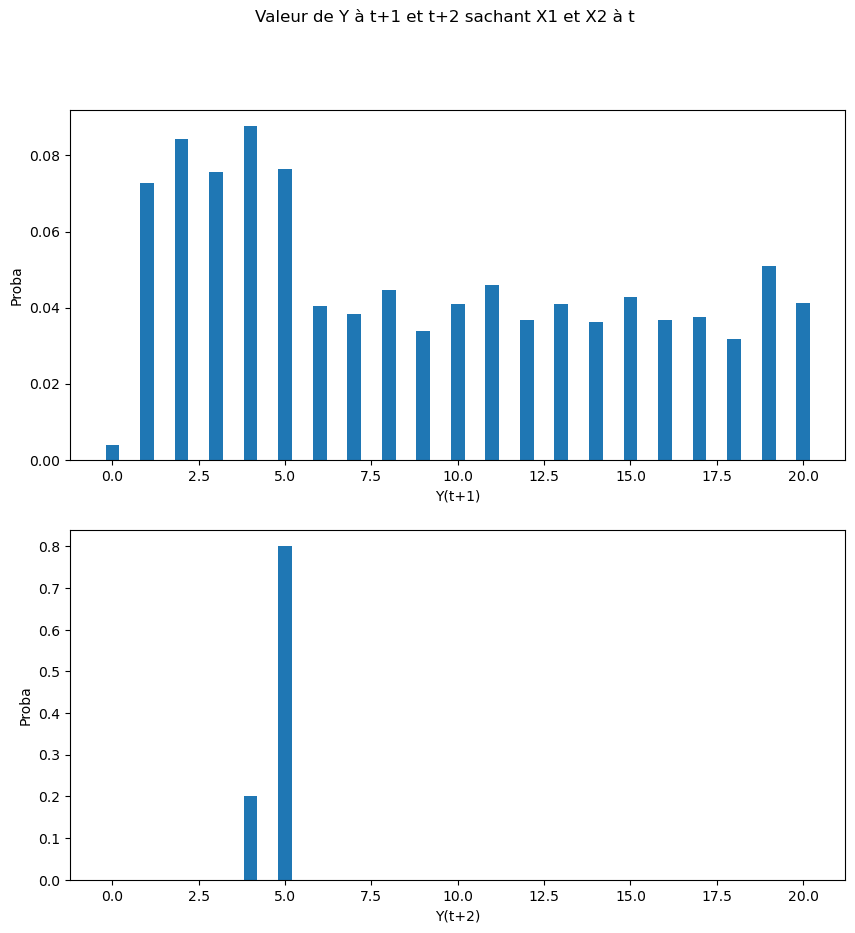

In [15]:
# framework pour l'inférence des DBN 
inference = DBNInference(dbn)

# known observation
evidence = {
#    ('X1', 0): 0, 
    ('X2', 0): 0, 
#    ('Y', 1): 0,
}  # value must be indice 

# result of question given evidence what about variable
result = inference.query(variables=[('Y', 1), ('Y', 0)], evidence=evidence)
proba_1 = result[("Y", 1)].values
proba_2 = result[("Y", 0)].values

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

fig.suptitle("Valeur de Y à t+1 et t+2 sachant X1 et X2 à t")

ax[0].bar(np.arange(len(proba_1)), proba_1, width=0.4)
ax[0].set_xlabel("Y(t+1)")
ax[0].set_ylabel("Proba")

ax[1].bar(np.arange(len(proba_2)), proba_2, width=0.4)
ax[1].set_xlabel("Y(t+2)")
ax[1].set_ylabel("Proba")

In [16]:
pd.unique(my_df_discretized[("X1", 0)]), pd.unique(my_df_discretized[("X2", 0)])

(array([-1, -2,  0,  1, -3, -4, -5, -6, -7,  2,  3,  4,  5,  6,  7,  8,  9,
        10, 11, 12, 13, 14, 15, 16, 17, 18]),
 array([ 0,  1,  2, -1, -2, -3, -4, -5,  3,  4,  5,  6,  7,  8,  9, 10, 11,
        12, 13, 14, 15, 16, 17, 18, 19]))

Text(0, 0.5, 'Proba')

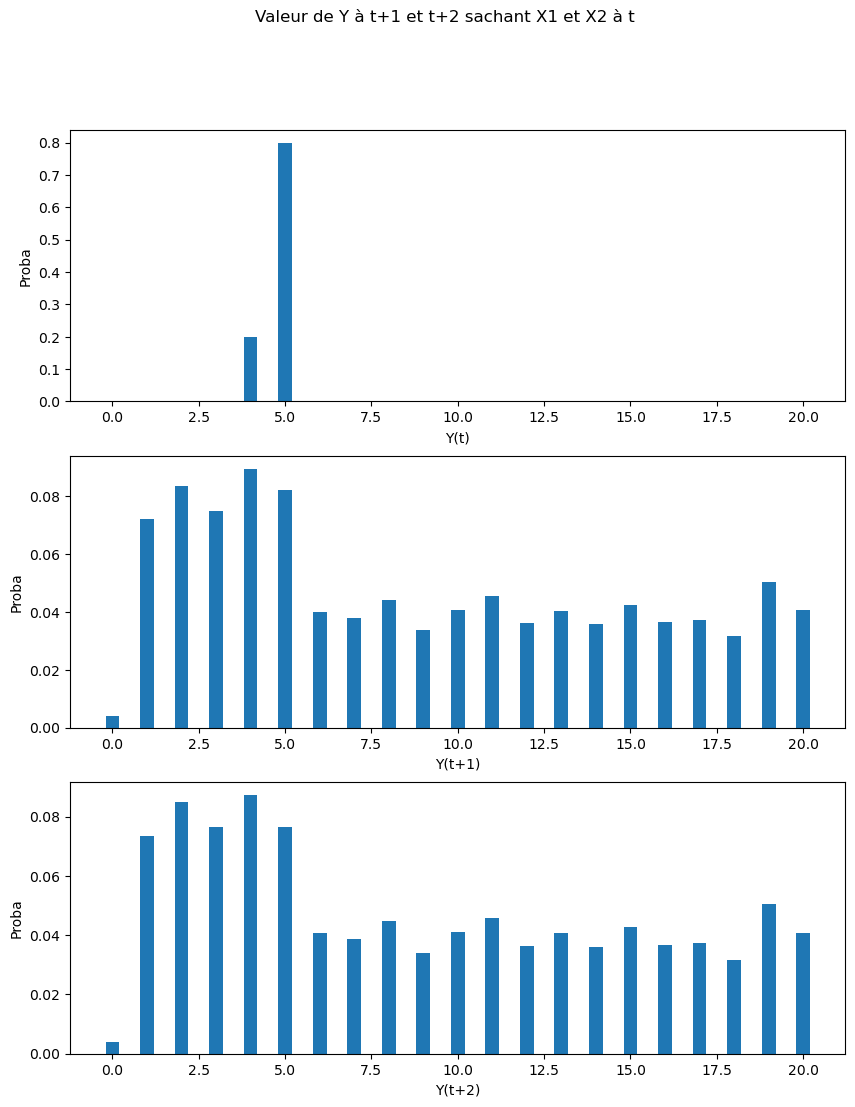

In [17]:
# framework pour l'inférence des DBN 
inference = DBNInference(dbn)

# known observation
evidence = {
#    ('X1', 0): 0, 
    ('X2', 0): 0, 
#    ('Y', 1): 0,
}  # value must be indice 

# result of question given evidence what about variable
result = inference.forward_inference(variables=[('Y', 0), ("Y", 1), ("Y", 2)], 
                                     evidence=evidence)
proba_0 = result[("Y", 0)].values
proba_1 = result[("Y", 1)].values
proba_2 = result[("Y", 2)].values



fig, ax = plt.subplots(3, 1, figsize=(10, 12))

fig.suptitle("Valeur de Y à t+1 et t+2 sachant X1 et X2 à t")

ax[0].bar(np.arange(len(proba_0)), proba_0, width=0.4)
ax[0].set_xlabel("Y(t)")
ax[0].set_ylabel("Proba")

ax[1].bar(np.arange(len(proba_1)), proba_1, width=0.4)
ax[1].set_xlabel("Y(t+1)")
ax[1].set_ylabel("Proba")

ax[2].bar(np.arange(len(proba_2)), proba_2, width=0.4)
ax[2].set_xlabel("Y(t+2)")
ax[2].set_ylabel("Proba")

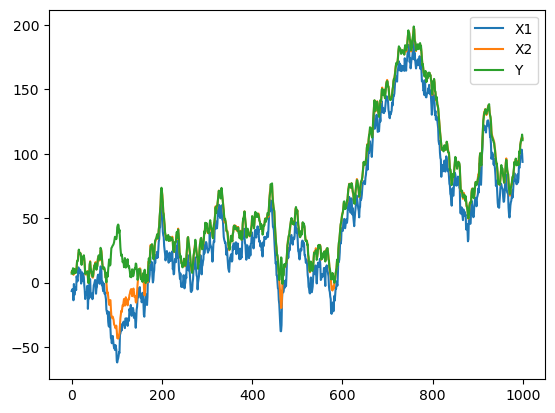

In [18]:
# nb of points 
x_axis = np.arange(nb_points)

plt.plot(x_axis, X1, label="X1")
plt.plot(x_axis, X2, label='X2')
plt.plot(x_axis, Y, label="Y")

plt.legend()
plt.show()

c:\Users\elkan\anaconda3\envs\time_series\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:491: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()


[        nan         nan 79.70462192 79.69812043 79.69812043]


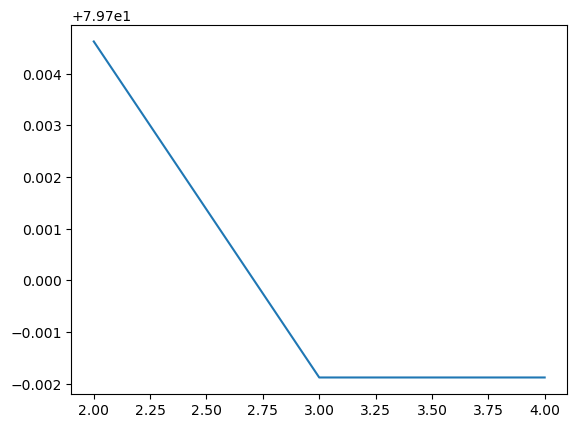

In [19]:
# framework pour l'inférence des DBN 
inference = DBNInference(dbn)
nb_pred = 5

# known observation
"""evidence = {
    ('X1', 0): 14, 
    ('X2', 0): 13, 
}  # value must be indice """
evidence = {
    ('X1', nb_pred): 1,
    ('X2', nb_pred): 2,
    ('X1', 0): 0, 
    ('X2', 0): 2,
}

# result of question given evidence what about variable
variables = [('Y', t) for t in range(0, nb_pred)]

result = inference.forward_inference(variables=variables, evidence=evidence)

pred = np.zeros(nb_pred)
y_values = sorted(list(pd.unique(my_df_discretized[("Y", 0)])))
for t in range(0, nb_pred):
    probas = result[("Y", t)].values
    pred[t] = np.dot(probas, y_values) * 10
    # print(probas)

print(pred)

plt.plot(np.arange(nb_pred), pred)
# plt.plot(np.arange(nb_pred), my_df[('Y', 0)].tail(nb_pred))
plt.show()

In [20]:
np.sqrt(1000)

31.622776601683793